In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

## Data preprocessing

In [2]:

train_dir = os.path.join('../models/train')
validation_dir = os.path.join('../models/val')
test_dir = os.path.join('../models/test')
BATCH_SIZE = 12
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 21998 files belonging to 6 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2442 files belonging to 6 classes.


In [4]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 600 files belonging to 6 classes.


Show the first nine images and labels from the training set:

In [5]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Print the true labels
print('True Labels:\n', true_labels)

True Labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

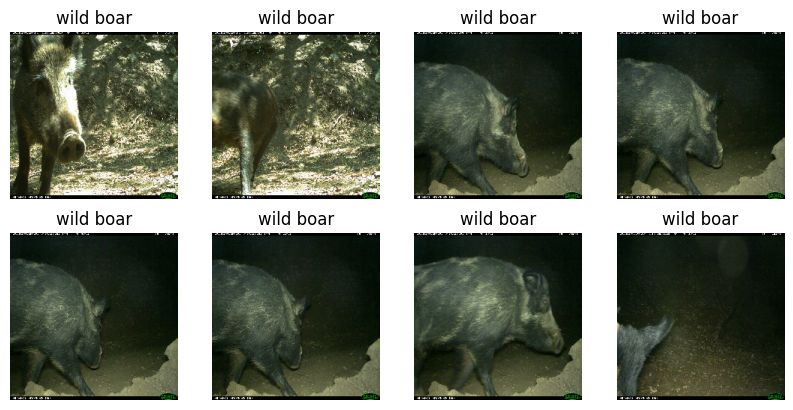

In [6]:
class_labels = ['dear', 'fox','leopard cat','porcupine','sumatran serow', 'wild boar']

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(178):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)



In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 204
Number of test batches: 50


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
    
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

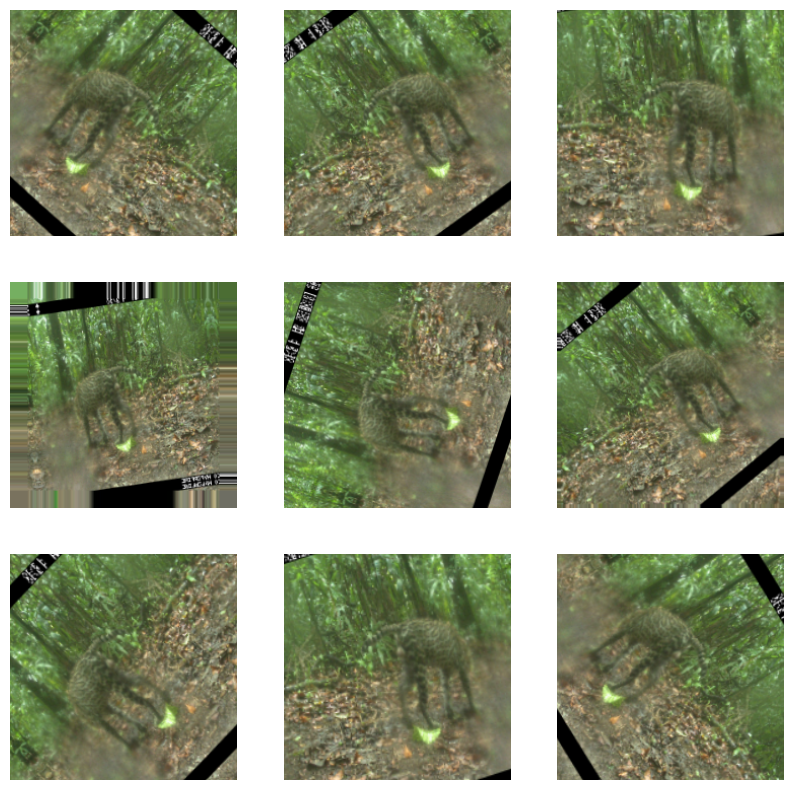

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
tf.keras.backend.clear_session()

In [13]:
resize_fn = tf.keras.layers.Resizing(224, 224)

train_dataset= train_dataset.map(lambda x, y: (resize_fn(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (resize_fn(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_fn(x), y))

In [14]:
augmentation_layers = [
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [15]:
def preprocess(images, labels):
  return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)


In [16]:
# import tensorflow as tf
# from tensorflow.keras.layers import BatchNormalization

# from kerastuner.tuners import RandomSearch
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# def build_model(hp):
#     IMG_SHAPE = IMG_SIZE + (3,)
    
#     # Base MobileNetV2 model
#     base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')
    
#     # Global average pooling layer
#     global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


#     # Input layer
#     inputs = tf.keras.Input(shape=(224, 224, 3))
    
#     # BatchNormalization layer
#     x = BatchNormalization()(inputs)
    
#     # Data augmentation
#     x = data_augmentation(x)
    
#     # Preprocess input
#     x = preprocess_input(x)
    
#     # Base MobileNetV2 model
#     x = base_model(x, training=False)
    
#     # Global average pooling
#     x = global_average_layer(x)
    
#     # Dropout layer with tunable rate
#     dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
#     # Dense prediction layer with L2 regularization
#     l2_reg_strength = hp.Float('l2_reg_strength', min_value=1e-4, max_value=1e-2, sampling='LOG')
#     prediction_layer = tf.keras.layers.Dense(len(class_labels), activation='softmax', name='prediction', 
#                                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg_strength))
#     outputs = prediction_layer(x)
    
#     # Build the model
#     model = tf.keras.Model(inputs, outputs)



#     # Compile the model
#     model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
#                   metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')
    
#     return model

# # Instantiate the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # Adjust the number of trials as needed
#     directory='keras_tuner_dir',
#     project_name='image_classification')

# # Define a callback to stop training early if there's no improvement
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Perform the search for the best hyperparameters
# tuner.search(train_dataset, epochs=9, validation_data=validation_dataset, callbacks=[early_stopping])

# # Get the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build the final model with the best hyperparameters
# final_model = tuner.hypermodel.build(best_hps)

In [17]:
# AUTOTUNE = tf.data.AUTOTUNE


# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.Resizing(224, 224),
#   tf.keras.layers.Rescaling(1./255)
# ])

# def prepare(ds, shuffle=False, augment=False):
#   # Resize and rescale all datasets.
#   ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)

#   if shuffle:
#     ds = ds.shuffle(1000)



#   # Use data augmentation only on the training set.
#   if augment:
#     ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
#                 num_parallel_calls=AUTOTUNE)

#   # Use buffered prefetching on all datasets.
#   return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
# train_dataset = prepare(train_dataset, shuffle=True, augment=True)
# validation_dataset = prepare(validation_dataset)
# test_dataset = prepare(test_dataset)

### Rescale pixel values

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [20]:
# rescale = tf.keras.layers.Rescaling(1./255, offset=-1)


In [21]:
# rescale = tf.keras.layers.Rescaling(1./255, offset=-1)

## Create the base model from the pre-trained convnets

In [22]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
inputs = tf.keras.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# import tensorflow as tf
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras import regularizers


# # Define data augmentation
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip('horizontal'),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
# ])

# # Preprocess input
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

# # Create the base model from the pre-trained model MobileNet V2
# IMG_SIZE = (224, 224)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

# # Define the rest of the model
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(6,activation='softmax',name='prediction',kernel_regularizer=regularizers.l2(0.01))

# # Construct the model
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(224, 224, 3)),
#     data_augmentation,  # Data augmentation should come first
#     BatchNormalization(),  # Then BatchNormalization
#     tf.keras.layers.Lambda(preprocess_input),
#     base_model,
#     global_average_layer,
#     tf.keras.layers.Dropout(0.5),
#     prediction_layer
# ])

In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(12, 7, 7, 1280)


## Feature extraction
In this step, will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally,add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [24]:
base_model.trainable = False

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(12, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [26]:
from tensorflow.keras import regularizers
prediction_layer = tf.keras.layers.Dense(6,activation='softmax',name='prediction',kernel_regularizer=regularizers.l2(0.01))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(12, 6)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [27]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(base_model.input,outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
          

In [28]:
# from tensorflow.keras.layers import BatchNormalization

# inputs = tf.keras.Input(shape=(224, 224, 3))
# # add BatchNormalization
# x= BatchNormalization()(inputs)
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(inputs, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

In [29]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['input_2', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_

In [30]:
import tensorflow as tf


# Print layer index and name
for layer_index, layer in enumerate(model.layers):
    print(model.layers)
    print(f"Layer {layer_index}: {layer.name}")

[<keras.engine.input_layer.InputLayer object at 0x0000019A92F67880>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019A91C417E0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000019A92F65D20>, <keras.layers.activation.relu.ReLU object at 0x0000019AEA8BA020>, <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000019A92D779A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000019A9191DA20>, <keras.layers.activation.relu.ReLU object at 0x0000019A9191D4B0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019A92F2FAF0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000019A92E28C40>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019AFE29AA40>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000019AEC415FF0>, <keras.layers.activation.relu.ReLU object at 0x0000019AFE499DB0>, <keras.layers.reshaping.zero_p

In [31]:
# from tensorflow.keras.layers import BatchNormalization

# inputs = tf.keras.Input(shape=(224, 224, 3))
# #add BatchNormalization
# x= BatchNormalization()(inputs)
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [33]:
base_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [34]:
# len(quant_aware_model.trainable_variables)

In [35]:

import tensorflow as tf
import os

# Set the number of parallel execution units
NUM_PARALLEL_EXEC_UNITS = 8

# Configuring TensorFlow Session
config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


# MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1"

In [36]:
model_name = "MobileNetV2_updated"

models_dir = os.path.join('./models')
model_dir = os.path.join(models_dir, model_name)
model_save_dir = os.path.join(model_dir, model_name)
model_save_path = os.path.join(model_save_dir, model_name + "_base.h5")


if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [37]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger
# Save the model with best weights
top_layers_file_path = os.path.join(model_save_dir, model_name + "_top_layers.h5")

# Save the model after every epoch.
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Save the TensorBoard logs.
tb = TensorBoard(log_dir='./logs', write_graph=True, update_freq='batch')
# Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor="loss", mode="min", patience=5)
# Save the CSV logger
csv_logger = CSVLogger('./logs/mobilenetv2-old-log.csv', append=True)

In [38]:
# Check if GPU is available
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
print("GPU Devices:", devices)

GPU Devices: []


In [39]:


from datetime import datetime


def accuracy_loss_plot(history, model_config):
    epochs = history.epoch
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    run_epochs = len(epochs)

    f = 1
    save_epochs = [epochs[i] for i in range(0, run_epochs, f)]
    save_tr_acc = [tr_acc[i] for i in range(0, run_epochs, f)]
    save_tr_loss = [tr_loss[i] for i in range(0, run_epochs, f)]
    save_val_acc = [val_acc[i] for i in range(0, run_epochs, f)]
    save_val_loss = [val_loss[i] for i in range(0, run_epochs, f)]

    # Create a figure and axis
    fig, ax1 = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)

    # Plot accuracy lines
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.plot(save_epochs, save_tr_acc, color='#800000', marker='o', label='Training Accuracy')
    ax1.plot(save_epochs, save_val_acc, color='#000075', marker='x', label='Validation Accuracy')
    # ax1.set_xticklabels(save_epochs, rotation=90)

    # Create a second y-axis for loss lines
    ax2 = ax1.twinx()  # Share the same x-axis
    ax2.set_ylabel('Loss', color='black')
    ax2.plot(save_epochs, save_tr_loss, color='#3cb44b', marker='s', label='Training Loss')
    ax2.plot(save_epochs, save_val_loss, color='#f58231', marker='^', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    # Set a title
    plt.title('Accuracy and Loss Over Epochs')

    accuracy_matrices_path = os.path.join(os.getcwd(), './metrics/accuracy_matrices')

    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-{model_config}-training_metrics_plot-{format(curr_datetime)}.png'

    if not os.path.exists(accuracy_matrices_path):
        os.makedirs(accuracy_matrices_path)

    # Save the plot to the specified folder
    destination = os.path.join(accuracy_matrices_path, filename)
    plt.savefig(destination, bbox_inches='tight')

### Compile the model

In [40]:
base_learning_rate = 0.0001

model. compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')


### Train the model


In [41]:
initial_epochs = 15
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
1834/1834 [==============================] - 1662s 902ms/step - loss: 1.3401 - accuracy: 0.5593 - top_k_categorical_accuracy: 0.8473 - val_loss: 0.7573 - val_accuracy: 0.7740 - val_top_k_categorical_accuracy: 0.9128
Epoch 2/15
1834/1834 [==============================] - 1193s 649ms/step - loss: 0.7468 - accuracy: 0.7802 - top_k_categorical_accuracy: 0.8183 - val_loss: 0.5772 - val_accuracy: 0.8346 - val_top_k_categorical_accuracy: 0.8714
Epoch 3/15
 538/1834 [=======>......................] - ETA: 15:52 - loss: 0.6504 - accuracy: 0.8121 - top_k_categorical_accuracy: 0.8129

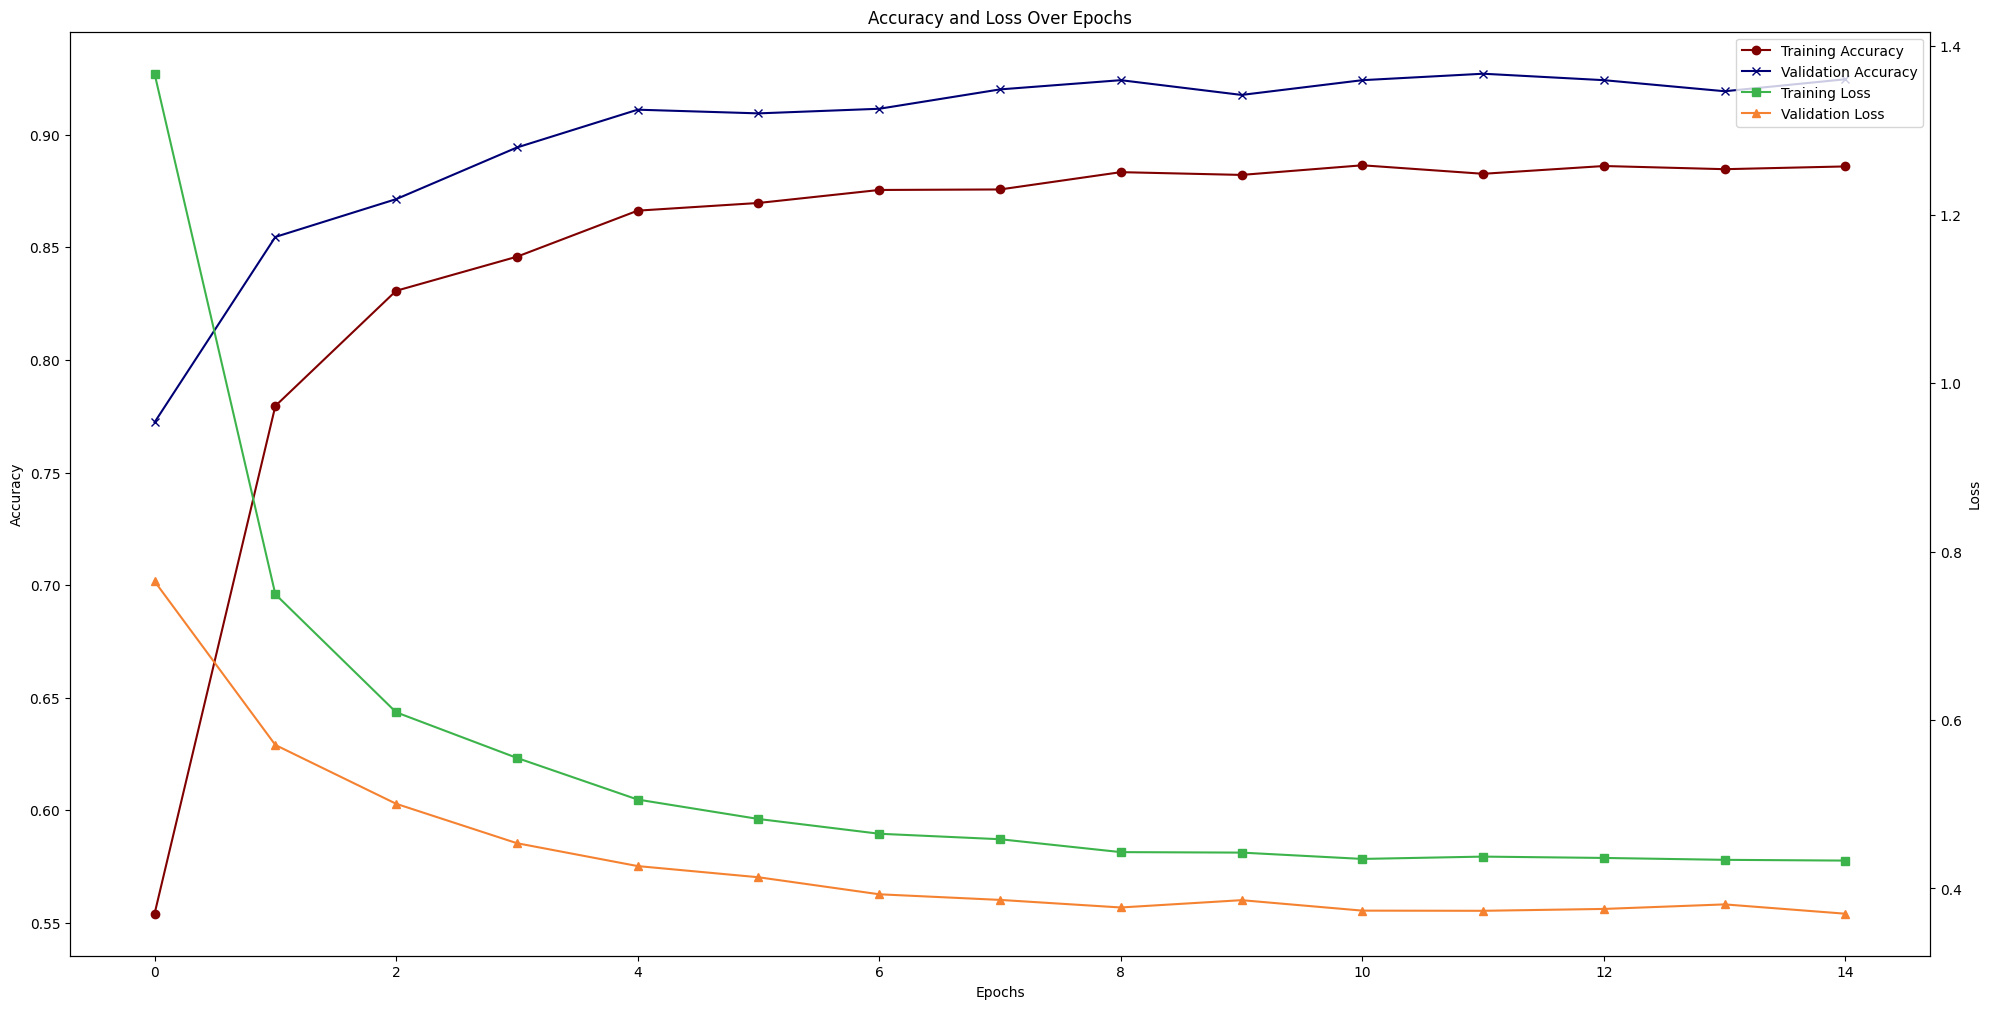

In [ ]:
accuracy_loss_plot(history, 'without_tuning')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)


[0.5540958046913147, 0.7795708775520325, 0.8307119011878967, 0.8458496332168579, 0.8663060069084167, 0.8697154521942139, 0.8754886984825134, 0.875715970993042, 0.8833984732627869, 0.882171094417572, 0.8864442110061646, 0.8826711773872375, 0.8861259818077087, 0.884716808795929, 0.8859441876411438]
[0.7723177671432495, 0.8546273708343506, 0.8714168667793274, 0.8943489193916321, 0.9111384153366089, 0.9095004200935364, 0.9115478992462158, 0.9201474189758301, 0.9242424368858337, 0.9176903963088989, 0.9242424368858337, 0.9271089434623718, 0.9242424368858337, 0.9193283915519714, 0.9246519207954407]


In [ ]:
#evaluating the model
accuracy = model.evaluate(validation_dataset)

204/204 [==============================] - 79s 378ms/step - loss: 0.3700 - accuracy: 0.9247 - top_k_categorical_accuracy: 0.8239


In [ ]:
accuracy = model.evaluate(test_dataset)

50/50 [==============================] - 26s 415ms/step - loss: 0.6376 - accuracy: 0.7967 - top_k_categorical_accuracy: 0.8583


In [ ]:

print("initial accuracy: {:.2f}".format(accuracy[1]))

initial accuracy: 0.80


### Learning curves

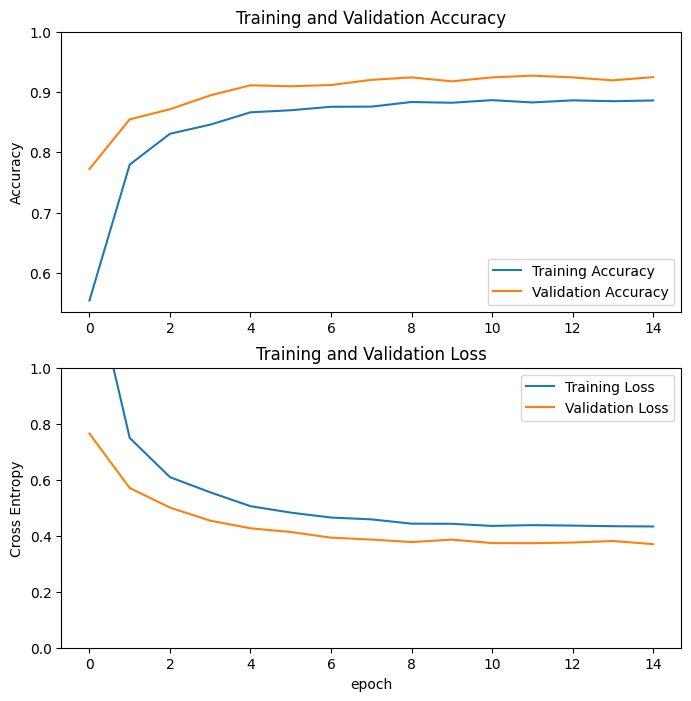

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
# Print all weights of the layers with layer name and number
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1} - Name: {layer.name}")
    weights = layer.get_weights()
    if weights:
        print("Weights:")
        for w in weights:
            print(w)
    else:
        print("No weights")
    print()

Layer 1 - Name: input_2
No weights

Layer 2 - Name: Conv1
Weights:
[[[[-1.71659231e-01 -3.33731920e-01  5.30122258e-02 -5.93232973e-21
     2.08742931e-01 -1.20433941e-01  1.75700430e-02 -3.10708203e-22
    -9.62498877e-03  1.90229788e-01 -3.67278278e-01  3.95997976e-22
    -2.36236629e-22  3.36706383e-22  8.83555040e-02 -7.75416642e-02
     3.95842289e-05 -3.63377742e-02  5.99925742e-02  5.53736472e-21
    -4.68022423e-04 -1.23387486e-01 -1.34351701e-01  8.75968020e-03
    -2.47503355e-01  1.58492010e-02 -2.43145856e-04 -1.09811597e-01
     5.55126644e-22 -2.03368161e-03  2.83311605e-01  7.66634047e-02]
   [-3.18941772e-01 -6.09864295e-01 -1.70770675e-01 -6.76705635e-21
    -5.82342505e-01 -2.56068230e-01 -4.18974347e-02  1.32427304e-22
     2.00757684e-04  3.29488933e-01 -4.01886106e-01  3.63034420e-22
     1.64733595e-22  1.97648923e-22  9.94425565e-02 -1.17755957e-01
     5.50664954e-05 -5.31860851e-02 -2.15648204e-01  3.16011650e-21
     8.09127018e-02  7.85512850e-02 -2.84253448e

Weights:
[[[[ 2.08213087e-02  5.91109321e-02  1.69177330e-03 ... -1.53706763e-02
    -1.07501885e-02 -7.96550326e-03]
   [ 1.47603964e-02  1.99404475e-03  4.16506336e-05 ... -8.28192085e-02
     1.64864659e-02 -8.25320631e-02]
   [-2.64817793e-02  3.42419520e-02 -6.33682162e-02 ... -2.23605409e-02
    -4.54954617e-02  2.45198695e-04]
   ...
   [ 2.38323268e-02 -1.75256468e-02 -4.31144945e-02 ...  8.41374621e-02
    -1.05844773e-02 -1.55945588e-02]
   [-2.12011039e-02  2.63821962e-03  6.54879771e-03 ... -5.84703609e-02
     1.05799297e-02 -4.06176150e-02]
   [-3.67201567e-02  4.37486060e-02  1.33012999e-02 ...  2.58587785e-02
     6.39340095e-03  3.21424492e-02]]]]

Layer 127 - Name: block_14_expand_BN
Weights:
[0.7449455  1.0069025  0.68565243 0.63665223 1.2058462  0.783787
 1.1308291  0.9992202  1.0909619  0.86382085 0.80180675 1.0192636
 1.1139675  1.2942237  1.1296188  1.0258297  1.215801   0.45319057
 1.1425266  1.002724   0.830293   0.68437123 0.9481198  1.5851147
 0.56644195 1.71

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()
  

Number of layers in the base model:  154
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                    

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(12, 7, 7, 1280)


### Compile the model

In [ ]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])


In [ ]:


# Summary of the quantization-aware model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
len(model.trainable_variables)

80

### Continue training the model

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/30
1834/1834 [==============================] - 1558s 837ms/step - loss: 0.4783 - accuracy: 0.8654 - top_k_categorical_accuracy: 0.8381 - val_loss: 0.2709 - val_accuracy: 0.9349 - val_top_k_categorical_accuracy: 0.8481
Epoch 16/30
1834/1834 [==============================] - 1522s 829ms/step - loss: 0.2956 - accuracy: 0.9287 - top_k_categorical_accuracy: 0.7789 - val_loss: 0.1949 - val_accuracy: 0.9648 - val_top_k_categorical_accuracy: 0.8468
Epoch 17/30
1834/1834 [==============================] - 1541s 839ms/step - loss: 0.2285 - accuracy: 0.9503 - top_k_categorical_accuracy: 0.7645 - val_loss: 0.1627 - val_accuracy: 0.9701 - val_top_k_categorical_accuracy: 0.8370
Epoch 18/30
1834/1834 [==============================] - 1487s 809ms/step - loss: 0.1959 - accuracy: 0.9598 - top_k_categorical_accuracy: 0.7635 - val_loss: 0.1620 - val_accuracy: 0.9701 - val_top_k_categorical_accuracy: 0.7977
Epoch 19/30
1834/1834 [==============================] - 1569s 854ms/step - loss: 0.1755

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


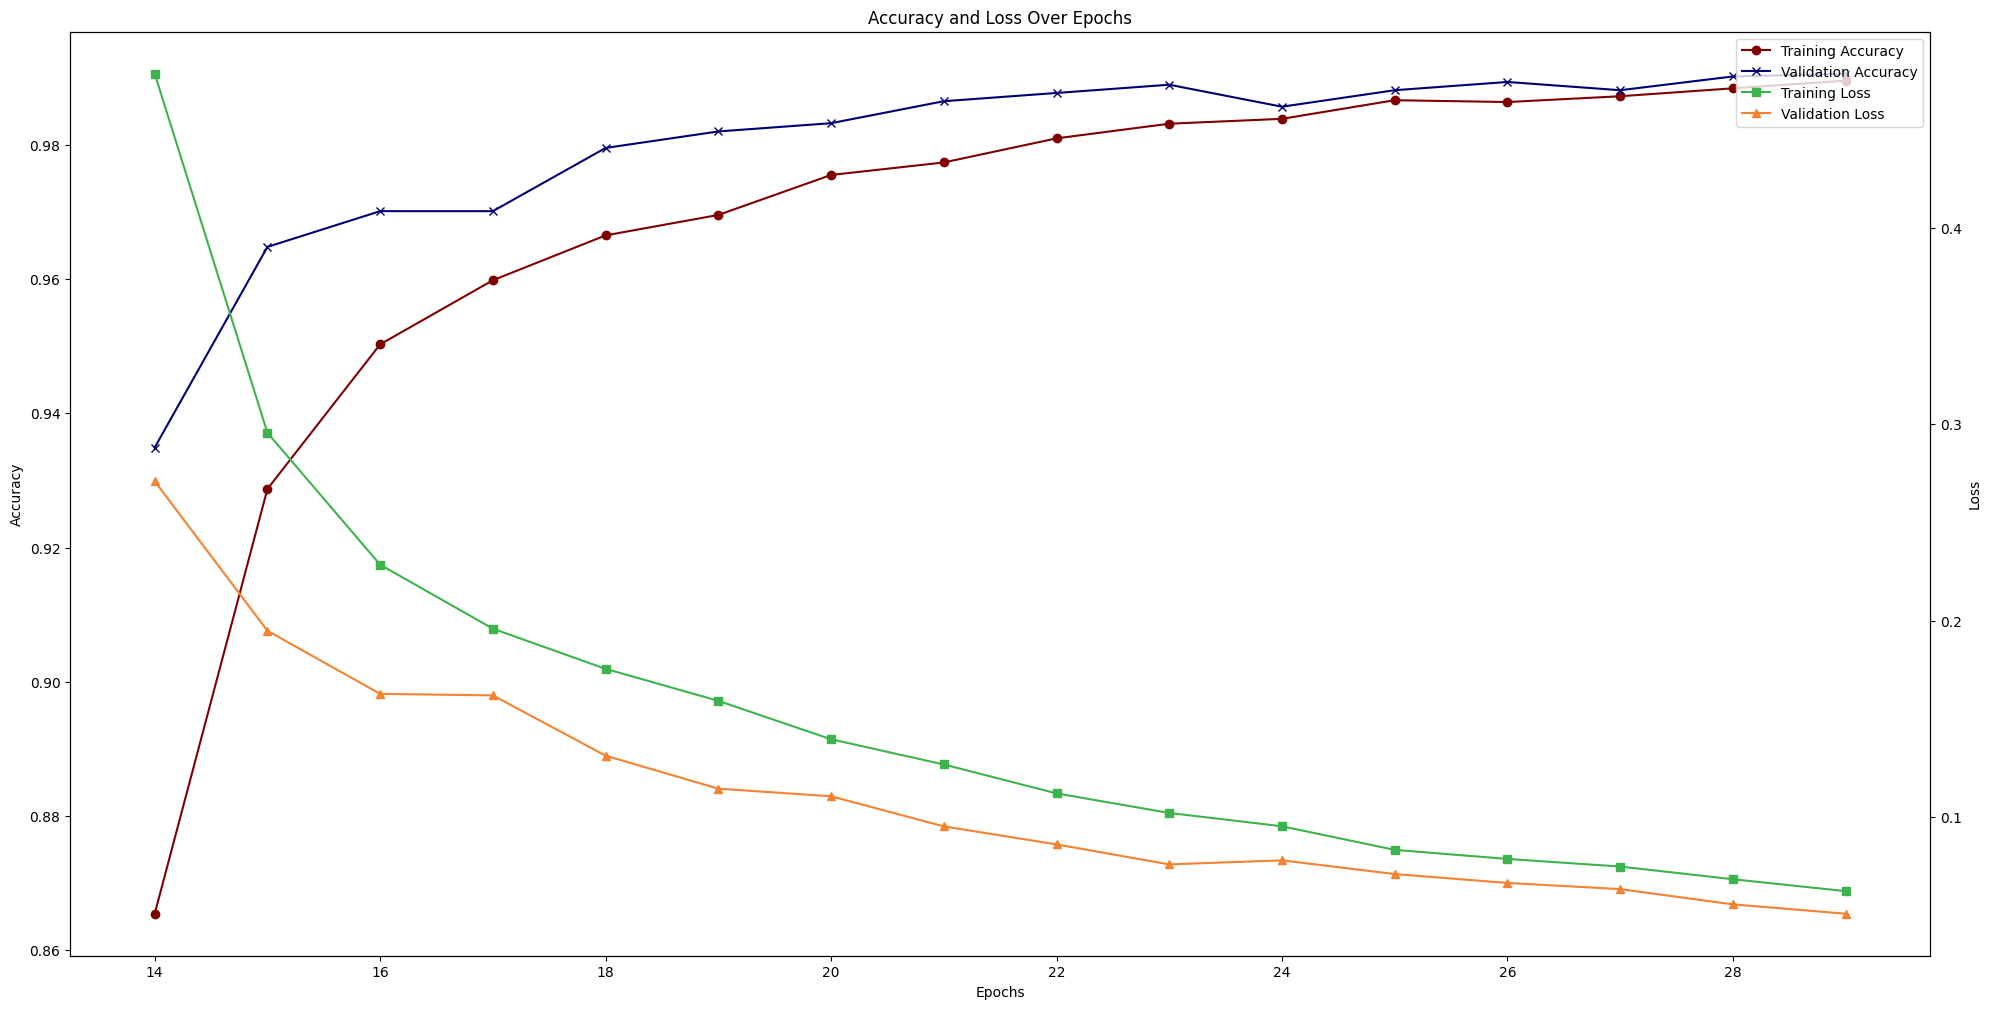

In [ ]:
accuracy_loss_plot(history_fine, 'with_tuning')

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

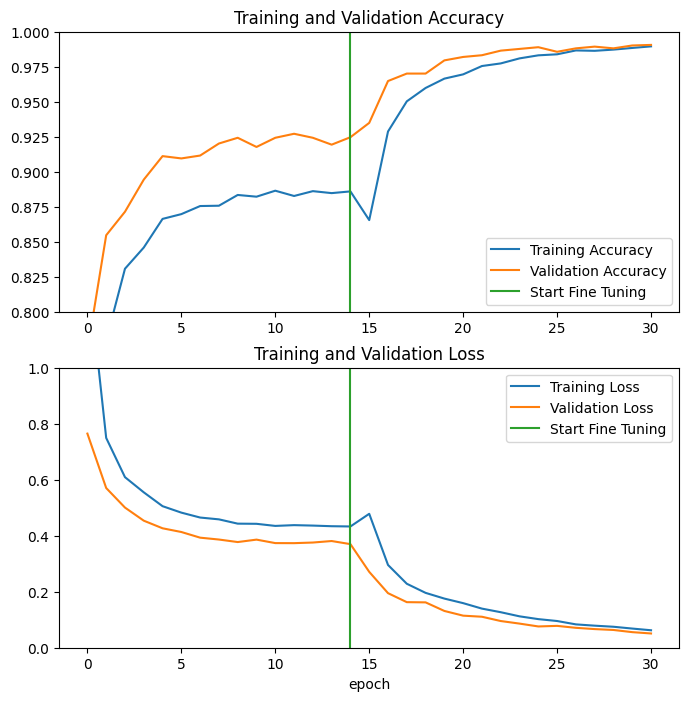

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy[1])

50/50 [==============================] - 63s 1s/step - loss: 0.3552 - accuracy: 0.8883 - top_k_categorical_accuracy: 0.9500
Test accuracy : 0.8883333206176758


In [ ]:
# Get the predictions for the test data
predictions = model.predict(test_dataset)

50/50 [==============================] - 18s 272ms/step


Predicted Classes:
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 4 0 0 4 0 0 0 0 0 0 0 0 0
 0 0 0 4 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 4 1
 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 4 1 4 4 1 4 5 5 5
 5 5 5 5 1 5 5 4 4 0 5 5 4 5 5 1 5 5 5 5 5 5 5 5 1 5 4 5 4 1 1 1 1 1 4 4 4
 5 4 3 5 2 4 5 0 4 1 5 5 5 5 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 

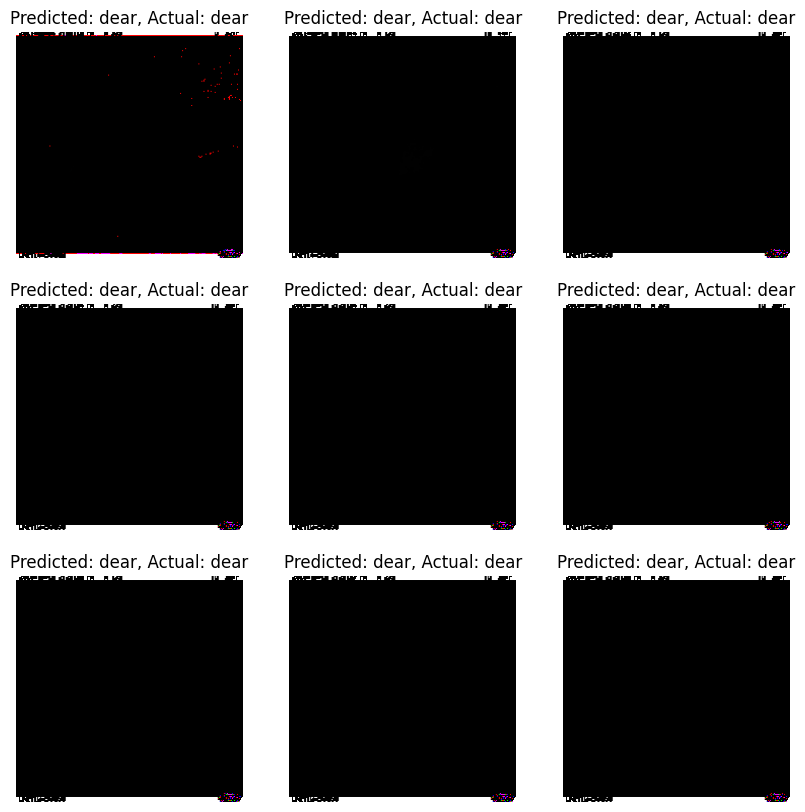

In [ ]:

# Apply argmax to get the predicted class
predicted_classes = tf.argmax(predictions, axis=1)


print('Predicted Classes:\n', predicted_classes.numpy())
print('True Classes:\n', np.array(true_labels))

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Predicted: {class_labels[predicted_classes[i]]}, Actual: {class_labels[labels[i]]}')
    plt.axis("off")


In [ ]:

from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


acc = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1 = f1_score(true_labels, predicted_classes, average='macro')

metrics_path = os.path.join(os.getcwd(), './metrics/metric_values')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-metrics-{format(curr_datetime)}.txt'

if not os.path.exists(metrics_path):
    os.makedirs(metrics_path)

file_path = os.path.join(metrics_path, filename)
with open(file_path, 'w') as file:
    file.write(f'Accuracy: {acc:.3f}\n')
    file.write(f'Precision: {precision:.3f}\n')
    file.write(f'Recall: {recall:.3f}\n')
    file.write(f'F1 Score: {f1:.3f}\n')
  
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

Accuracy: 0.888
Precision: 0.908
Recall: 0.888
F1 Score: 0.878


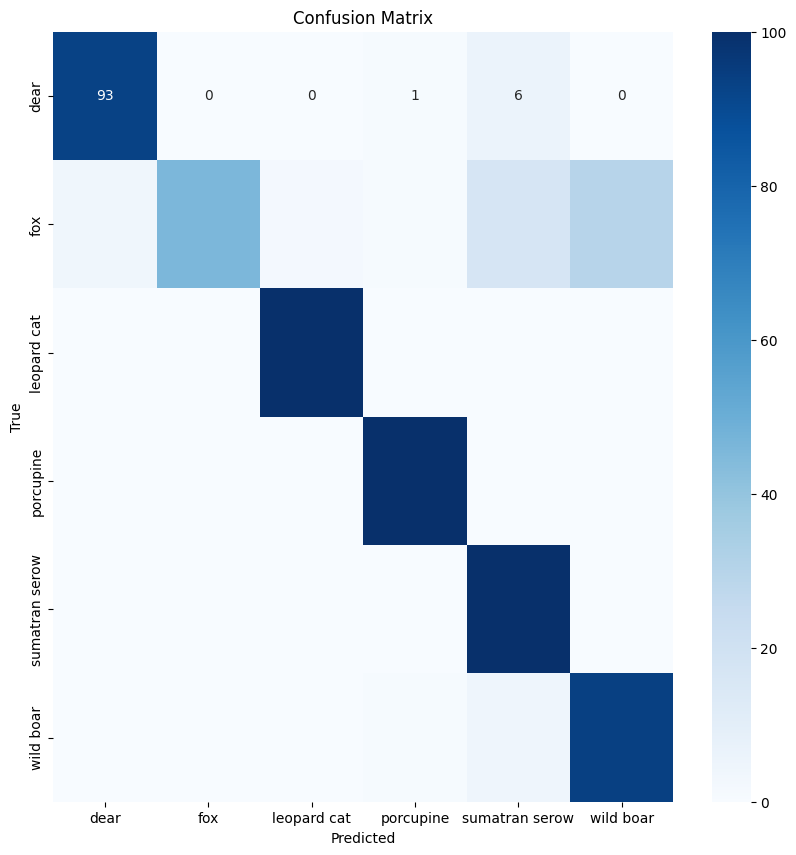

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_res = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_res, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

confusion_matrix_path = os.path.join(os.getcwd(), './metrics_mobilnet/confusion_matrices')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{"mobilnetv2-old"}-confusion_matrix-{format(curr_datetime)}.png'

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)

# Save the plot to the specified folder
save_path = os.path.join(confusion_matrix_path, filename)
plt.savefig(save_path, bbox_inches='tight')

In [ ]:
from datetime import datetime
from itertools import cycle
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve

model_name = 'MobileNetV2_Updated'
num_labels=6

def get_ROC_AUC(y_pred, y_target):
    # Binarize the labels
    n_classes = num_labels
    true_labels_bin = label_binarize(y_target, classes=range(n_classes))
    predicted_labels_bin = label_binarize(y_pred, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        print()
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i],drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def save_ROC_AUC(fpr, tpr, roc_auc):
    n_classes = num_labels

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))

    hex_colors = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#FFA500",  # Orange
        "#FF4500",  # OrangeRed
        "#FFD700",  # Gold
        "#8A2BE2",  # BlueViolet
        "#7FFF00",  # Chartreuse
        "#DC143C",  # Crimson
        "#48D1CC",  # MediumTurquoise
        "#2E8B57",  # SeaGreen
        "#800080",  # Purple
        "#ADFF2F",  # GreenYellow
        "#FF1493",  # DeepPink
        "#9370DB",  # MediumPurple
        "#8B4513",  # SaddleBrown
        "#20B2AA",  # LightSeaGreen
        "#8B008B",  # DarkMagenta
        "#FF6347",  # Tomato
        "#556B2F",  # DarkOliveGreen
        "#6B8E23",  # OliveDrab
        "#BDB76B",  # DarkKhaki
        "#808080",  # Gray
        "#DAA520",  # GoldenRod
    ]

    colors = cycle(hex_colors)  # Adjust as needed for your number of classes

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve and AUC')
    plt.legend(loc='lower right')

    roc_auc_path = os.path.join(os.getcwd(), './metrics/roc_auc')
    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-roc_auc-{format(curr_datetime)}.png'

    if not os.path.exists(roc_auc_path):
        os.makedirs(roc_auc_path)

    # Save the plot to the specified folder
    save_path = os.path.join(roc_auc_path, filename)
    plt.savefig(save_path, bbox_inches='tight')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes.numpy(),target_names = class_labels))

                precision    recall  f1-score   support

          dear       0.96      0.93      0.94       100
           fox       1.00      0.46      0.63       100
   leopard cat       0.98      1.00      0.99       100
     porcupine       0.97      1.00      0.99       100
sumatran serow       0.78      1.00      0.88       100
     wild boar       0.76      0.94      0.84       100

      accuracy                           0.89       600
     macro avg       0.91      0.89      0.88       600
  weighted avg       0.91      0.89      0.88       600



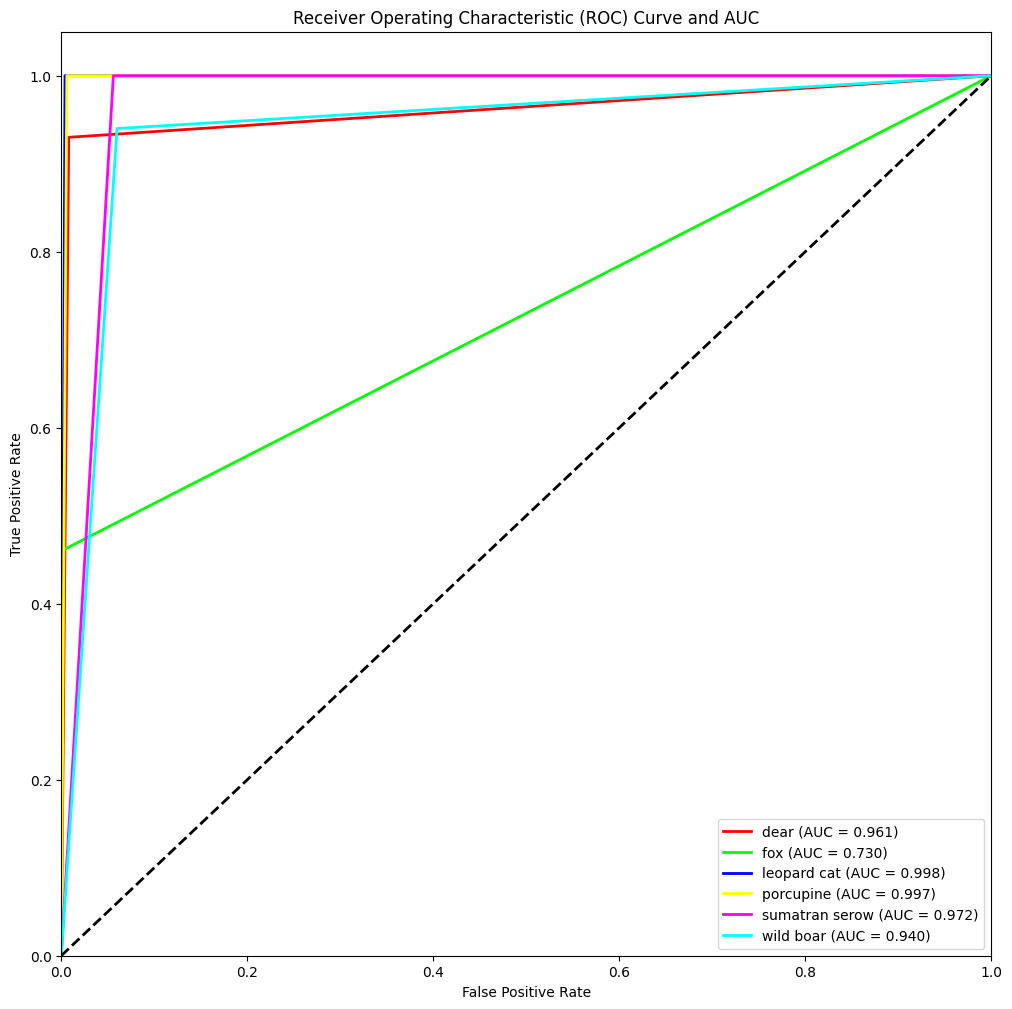

In [ ]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_classes, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

In [ ]:
#save weights of the trained model to the specified folder
model.save_weights(os.path.join(model_save_dir, model_name + "_weights.h5"))

In [ ]:
#save model to the specified folder
model_file_path = os.path.join(model_save_dir, model_name + ".h5")
model.save(model_file_path)
model_size_bytes = os.path.getsize(model_file_path)
model_size_megabytes = model_size_bytes / (1024 * 1024)  # Convert bytes to megabytes

print("Model size: {:.2f} megabytes".format(model_size_megabytes))

Model size: 17.16 megabytes


## Prune and fine-tune the model to 50% sparsity

Apply the prune_low_magnitude() API to achieve the pruned model that is to be clustered in the next step.

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
  }

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model = prune_low_magnitude(model, **pruning_params)

In [ ]:
pruned_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
# Summary of the quantization-aware model
pruned_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, 112, 112, 32  1730       ['input_2[0][0]']                
 neLowMagnitude)                )                                                                 
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, 112, 112, 32  129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             )                                ']                           

In [ ]:
fine_tune_pruning_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs + fine_tune_pruning_epochs
history_fine_tune_pruning_ = pruned_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)


Epoch 30/40
1338/1834 [====================>.........] - ETA: 8:08 - loss: 0.1046 - accuracy: 0.9754 - top_k_categorical_accuracy: 0.8936

KeyboardInterrupt: 

In [ ]:
accuracy = pruned_model.evaluate(test_dataset)
print('Test accuracy :', accuracy[1])

In [ ]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )

Let's strip the pruning wrapper first, then check that the model kernels were correctly pruned.

In [ ]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

print_model_weights_sparsity(stripped_pruned_model)

## Apply sparsity preserving clustering and check its effect on model sparsity in both cases

Next, apply sparsity preserving clustering on the pruned model and observe the number of clusters and check that the sparsity is preserved.

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': 8,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

sparsity_clustered_model = cluster_weights(stripped_pruned_model, **clustering_params)

In [ ]:
sparsity_clustered_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
# Summary of the quantization-aware model
sparsity_clustered_model.summary()

In [ ]:
fine_tune_sparcity_clusturing_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs+fine_tune_pruning_epochs+fine_tune_sparcity_clusturing_epochs

history_fine_tune_sparcity_clusturing = sparsity_clustered_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch= history_fine_tune_pruning_.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
accuracy = sparsity_clustered_model.evaluate(test_dataset)
print('Test accuracy :', accuracy[1])

# Create Non quantized model for TFLite backend

In [ ]:
model=sparsity_clustered_model

In [ ]:
#convert to tflite and save to new folder called tflite_models
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = os.path.join(os.getcwd(), 'tflite_models')
tflite_model_dir = os.path.join(tflite_models_dir, model_name)

if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_save_path = os.path.join(tflite_model_dir, model_name + ".tflite")
with open(tflite_model_save_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DINUKA~1\AppData\Local\Temp\tmpmiwafnlb\assets


INFO:tensorflow:Assets written to: C:\Users\DINUKA~1\AppData\Local\Temp\tmpmiwafnlb\assets


In [ ]:
# Get the size of the TFLite model in megabytes
tflite_model_size_bytes = len(tflite_model)
tflite_model_size_mb = tflite_model_size_bytes / (1024 * 1024)  # Convert bytes to megabytes
print("Size of the TFLite model:", tflite_model_size_mb, "MB")


Size of the TFLite model: 8.476730346679688 MB


# Inference Process

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Open image and resize
img_path = './Random_outside_predictions/malayan-porcupine_1497.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # Normalize pixel values to be between 0 and 1

# Load the model
general_model = tf.keras.models.load_model('models/MobileNetV2_updated/MobileNetV2_updated/MobileNetV2_updated.h5')
interpreter = tf.lite.Interpreter(model_path='./tflite_models/MobileNetV2_Updated/MobileNetV2_Updated.tflite')
interpreter.allocate_tensors()  # Allocate tensors

# Make predictions
predictions = model.predict(img_array)
# pred_prob = model.predict_proba(test_dataset)
print(predictions)

# Get the index of the highest probability class
predicted_class_index = np.argmax(predictions, axis=1)
print("Predicted label from general model:",class_labels[predicted_class_index[0]])

# Perform inference
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Post-process the output
predicted_class_index = np.argmax(output_data)

print("Predicted label from Tflite model:",class_labels[predicted_class_index])

1/1 [==============================] - 2s 2s/step
[[4.0610216e-04 2.6654644e-04 5.5685863e-02 9.2101860e-01 2.2561660e-02
  6.1235332e-05]]
Predicted label from general model: porcupine
Predicted label from Tflite model: porcupine


In [ ]:
print(predictions)

[[9.99796093e-01 2.03625950e-05 5.77840146e-05 1.40067950e-05
  1.07602187e-04 4.12850068e-06]
 [9.94476974e-01 1.61819265e-03 9.12543328e-05 5.77504870e-05
  2.06364924e-03 1.69215177e-03]
 [9.05327916e-01 3.19945216e-02 2.46631657e-03 1.01415790e-03
  4.23351824e-02 1.68620311e-02]
 ...
 [3.84319499e-02 1.49185266e-02 7.75601417e-02 3.36861461e-01
  3.15845400e-01 2.16382548e-01]
 [2.63535767e-03 6.14643656e-03 4.51753673e-04 2.06691935e-03
  1.04950346e-01 8.83749247e-01]
 [4.06184663e-05 4.08090309e-05 5.90539048e-06 2.00609861e-06
  4.36767878e-04 9.99473870e-01]]


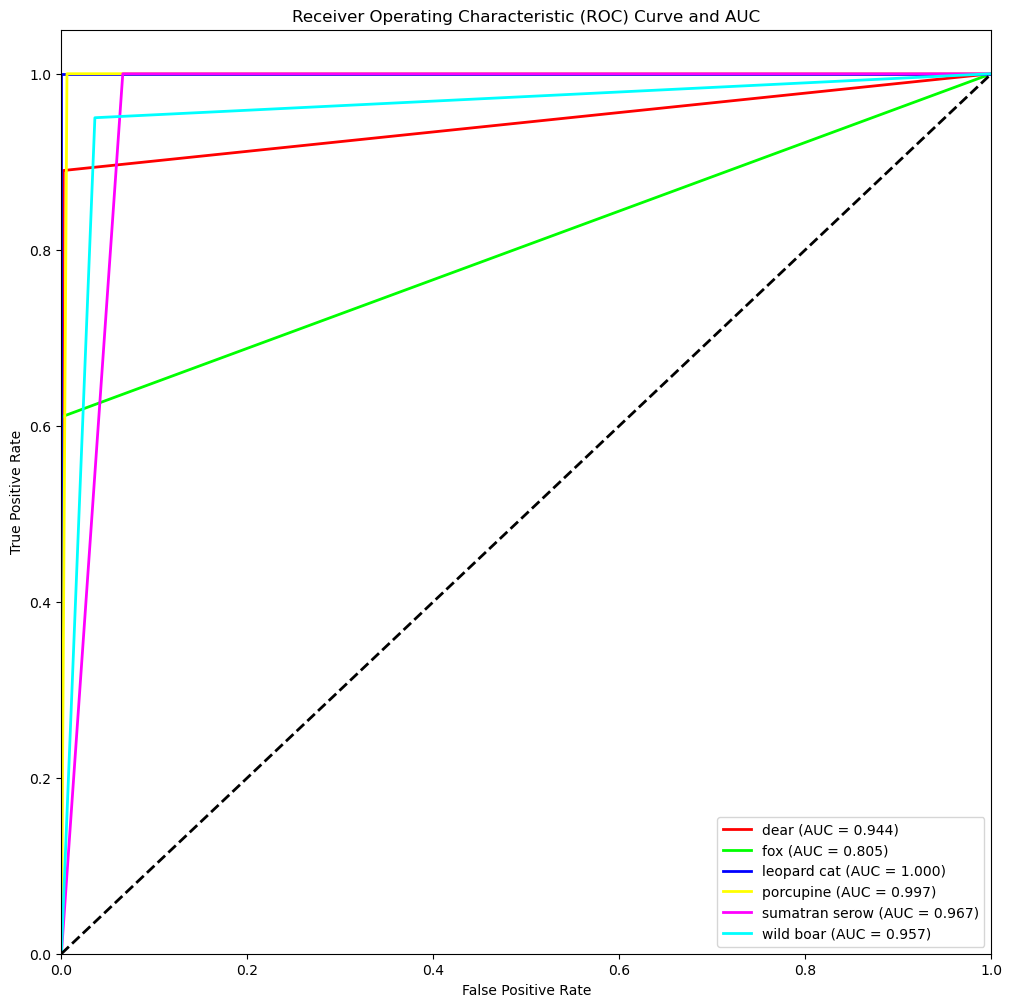

In [ ]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_class_index, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

In [ ]:

from sklearn.metrics import classification_report


#load tf lite model and want to calculate accuracy of the compressed model
interpreter = tf.lite.Interpreter(model_path='./tflite_models/MobileNetV2_Updated/MobileNetV2_Updated.tflite')

true_labels = true_labels
predicted_labels = []

for images, labels in test_dataset:
    for image in images:
        image = tf.expand_dims(image, axis=0)
        interpreter.allocate_tensors()
        interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image)
        interpreter.invoke()
        preds = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
        preds = np.argmax(preds, axis=1)
        predicted_labels.extend(preds)

print(classification_report(true_labels, predicted_labels, target_names=class_labels))




                precision    recall  f1-score   support

          dear       0.99      0.89      0.94       100
           fox       1.00      0.61      0.76       100
   leopard cat       1.00      1.00      1.00       100
     porcupine       0.97      1.00      0.99       100
sumatran serow       0.75      1.00      0.86       100
     wild boar       0.84      0.95      0.89       100

      accuracy                           0.91       600
     macro avg       0.93      0.91      0.91       600
  weighted avg       0.93      0.91      0.91       600

